In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.utils import generic_utils
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import math
import h5py
import time
import copy
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

Using TensorFlow backend.


In [2]:
#x = np.array([2, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
#y = np.array([1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
#x = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
#y = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
#x = np.array([0, 0, 1, 2, 1, 0, 1, 0, 0])
#y = np.array([0, 1, 2, 0, 0, 0, 0, 0, 0])
x = np.array([1, 2, 3, 2, 2.13, 1])
y = np.array([1, 1, 2, 2, 2.42, 3, 2, 1])
euclidean_norm = lambda x, y: np.abs(x - y)
def dtw(x, y, func):
    cost_matrix = np.empty((len(y), len(x)))
    cost_matrix.fill(np.nan)
    for i in range(len(y)):
        for j in range(len(x)):
            cost_matrix[i, j] = func(x[j], y[i])
    acc_cost_matrix = np.empty((len(y), len(x)))
    acc_cost_matrix.fill(np.nan)
    
    #print(acc_cost_matrix.shape)
    #print(cost_matrix.shape)
    acc_cost_matrix[0, 0] = cost_matrix[0, 0]
    for i in range(1, len(y)):
        acc_cost_matrix[i, 0] = acc_cost_matrix[i-1, 0] +\
                                cost_matrix[i, 0]
    for j in range(1, len(x)):
        acc_cost_matrix[0, j] = acc_cost_matrix[0, j-1] +\
                                cost_matrix[0, j]
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            acc_cost_matrix[i, j] = cost_matrix[i, j] + \
                                    min(acc_cost_matrix[i-1, j],
                                        acc_cost_matrix[i, j-1],
                                        acc_cost_matrix[i-1, j-1])
    path_x = []
    path_y = []
    x_idx = len(x)-1
    y_idx = len(y)-1
    path_x.append(x_idx)
    path_y.append(y_idx)
    while y_idx != 0 or x_idx != 0:
        if y_idx >= 1 and x_idx >= 1:
            up = acc_cost_matrix[y_idx-1, x_idx]
            diag = acc_cost_matrix[y_idx-1, x_idx-1]
            acro = acc_cost_matrix[y_idx, x_idx-1]
            if min(up, diag, acro) == diag:
                x_idx -= 1
                y_idx -= 1
            elif min(up, diag, acro) == up:
                y_idx -= 1
            elif min(up, diag, acro) == acro:
                x_idx -= 1     
        elif y_idx == 0:
            x_idx -= 1
        elif x_idx == 0:
            y_idx -= 1
        path_x.append(x_idx)
        path_y.append(y_idx)
    path_x = path_x[::-1]
    path_y = path_y[::-1]
    
    distance = acc_cost_matrix[len(y)-1, len(x)-1]
    path = np.array([path_x, path_y])
    return distance, cost_matrix, acc_cost_matrix, path
distance, cost_matrix, acc_cost_matrix, path = dtw(x, y, euclidean_norm)
print(path[0])
print(path[1])

[0 0 1 1 1 2 3 4 5]
[0 1 2 3 4 5 6 6 7]


(2, 9)
0.5499999999999998
[[0.   1.   3.   4.   5.13 5.13]
 [0.   1.   3.   4.   5.13 5.13]
 [1.   0.   1.   1.   1.13 2.13]
 [2.   0.   1.   1.   1.13 2.13]
 [3.42 0.42 0.58 1.   1.29 2.55]
 [5.42 1.42 0.42 1.42 1.87 3.29]
 [6.42 1.42 1.42 0.42 0.55 1.55]
 [6.42 2.42 3.42 1.42 1.55 0.55]]


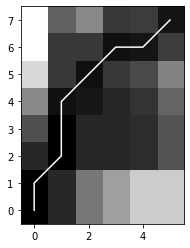

In [3]:
print(path.shape)
print(distance)
print(acc_cost_matrix)
pyplot.imshow(acc_cost_matrix, origin='lower', cmap='gray', interpolation='nearest')
pyplot.plot(path[0], path[1], 'w')
pyplot.show()

In [4]:
VIEW_df = pd.read_csv('/home/whsu014/data/Cholesterol_PHH_360dayspy_with_true_values_01day_ethn_coded_PREDICT_Variables_sbp2dbp2.csv')
print(VIEW_df.shape)
print(VIEW_df.columns)
VIEW_sub_df = VIEW_df[['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 
                       'AGE', 'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 
                       'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS', 
                       'ATORVASTATIN', 'SIMVASTATIN', 
                       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL',
                       'TRUE_TCHDL', 'SBP', 'DBP',
                       'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 
                       'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 
                       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR']]
print(VIEW_sub_df.shape)
print(VIEW_sub_df.isnull().sum())

(2099160, 51)
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE',
       'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL',
       'TCHDL', 'STATINS', 'ATORVASTATIN', 'SIMVASTATIN',
       'CHOLESTEROL_LOWERING', 'ARBs', 'ACE', 'ALPHA_BLOCKERS',
       'BETA_BLOCKERS', 'BLOOD_PRESSURE_LOWERING', 'LIPID_LOWERING',
       'DIURETICS', 'ANTIANGINAL_ANTIARRYTHMIC', 'CALCIUM_CHANNEL_BLOCKERS',
       'ANTIHYPERTENSIVES', 'CARDIAC_GLYCOSIDES', 'NITRATES',
       'SYMPATHOMIMETIC', 'OTHERS', 'ANTIPLATELETS', 'ANTICOAGULANTS',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL', 'SBP',
       'SMOKING', 'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'DBP', 'HX_CVD',
       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'SBP2', 'DBP2'],
      dtype='object')
(2099160, 33)
STUDENT_INDEX_MASTER          0
DATE                          0
QUARTERS                      0
AGE                           0
ETHNICITY                     0
SEX                      

In [5]:
# Count size of ethnicity groups
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'D'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'F'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'G'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H'].shape[0]//28)

3611
44538
6552
1243
7390
50
2358
9228


In [6]:
# Combine D, F and G
VIEW_sub_A_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A']
VIEW_sub_B_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B']
VIEW_sub_C_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C']
VIEW_sub_D_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY.isin(['D', 'F', 'G'])] # MELAA, Other and Other_Asian
VIEW_sub_E_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E']
VIEW_sub_H_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H']
print(VIEW_sub_A_df.shape[0]//28)
print(VIEW_sub_B_df.shape[0]//28)
print(VIEW_sub_C_df.shape[0]//28)
print(VIEW_sub_D_df.shape[0]//28)
print(VIEW_sub_E_df.shape[0]//28)
print(VIEW_sub_H_df.shape[0]//28)

3611
44538
6552
3651
7390
9228


In [7]:
# random sampling unique ID 
# to control ethn imbalance
ethn_A_list = VIEW_sub_A_df.STUDENT_INDEX_MASTER.unique()
ethn_B_list = VIEW_sub_B_df.STUDENT_INDEX_MASTER.unique()
ethn_C_list = VIEW_sub_C_df.STUDENT_INDEX_MASTER.unique()
ethn_D_list = VIEW_sub_D_df.STUDENT_INDEX_MASTER.unique()
ethn_E_list = VIEW_sub_E_df.STUDENT_INDEX_MASTER.unique()
ethn_H_list = VIEW_sub_H_df.STUDENT_INDEX_MASTER.unique()
ethn_A_sample = list(np.random.choice(ethn_A_list, 3500, replace=False))
ethn_B_sample = list(np.random.choice(ethn_B_list, 3500, replace=False)) # over sample Europeans
ethn_C_sample = list(np.random.choice(ethn_C_list, 3500, replace=False)) # to make a data of 
ethn_D_sample = list(np.random.choice(ethn_D_list, 3500, replace=False)) # 20,000 individuals
ethn_E_sample = list(np.random.choice(ethn_E_list, 3500, replace=False)) # 3335 all others 3333
ethn_H_sample = list(np.random.choice(ethn_H_list, 3500, replace=False))
print(VIEW_sub_df.shape)
ethn_sample = ethn_A_sample + ethn_B_sample + ethn_C_sample + \
              ethn_D_sample + ethn_E_sample + ethn_H_sample
VIEW_sub_df = VIEW_sub_df[VIEW_sub_df.STUDENT_INDEX_MASTER.isin(ethn_sample)]
print(VIEW_sub_df.shape)

(2099160, 33)
(588000, 33)


In [8]:
#########################################
# only cluster 20 quarters after PREDICT
#########################################
'''
DTW5to13clusters2500inds28quarters = pd.read_csv('/home/whsu014/data/DTW5to13Clusters_2500inds28quarters.csv')
print(DTW5to13clusters2500inds28quarters.shape)
print(DTW5to13clusters2500inds28quarters.columns)
print(len(np.unique(DTW5to13clusters2500inds28quarters.iloc[:, 1])))
ID_list = np.unique(DTW5to13clusters2500inds28quarters.iloc[:, 1])
'''
DTW_quarters = [8,9,10,11,12,13,14,15,16,17,18,19,\
                20,21,22,23,24,25,26,27,]
print(VIEW_sub_df.shape)
#DTW_VIEW_sub_df = VIEW_sub_df[VIEW_sub_df.STUDENT_INDEX_MASTER.isin(ID_list)]
#print(DTW_VIEW_sub_df.shape)
#DTW_VIEW_sub_df = DTW_VIEW_sub_df[DTW_VIEW_sub_df.QUARTERS.isin(DTW_quarters)]
#DTW_VIEW_sub_df = VIEW_sub_df
#print(DTW_VIEW_sub_df.shape)
#DTW_VIEW_v = DTW_VIEW_sub_df.values
DTW_VIEW_v = VIEW_sub_df[VIEW_sub_df.QUARTERS.isin(DTW_quarters)].values
print(DTW_VIEW_v.shape)

(588000, 33)
(420000, 33)


In [9]:
##################################
# normalise and J-normalise data
##################################

print(len(DTW_VIEW_v)//20)
z = np.zeros((len(DTW_VIEW_v), 1))
z[:, :] = np.nan
DTW_VIEW_v = np.append(DTW_VIEW_v, z, axis=1)
print(DTW_VIEW_v.shape)
print(DTW_VIEW_v.base is z)

######################
# J - normalise data
######################

for i in range(len(DTW_VIEW_v)//20):  # len(DTW_VIEW_v)//28
    ind_TCHDL = np.copy(DTW_VIEW_v[(i*20):((i+1)*20), 12])
    base_TCHDL = ind_TCHDL[7]
    updated_TCHDL = ind_TCHDL - base_TCHDL
    
    #print("Ind: ", ind_TCHDL)
    #print("Base: ", base_TCHDL)
    #print("Updated: ", updated_TCHDL)
    #print(updated_TCHDL.base is ind_TCHDL)
    DTW_VIEW_v[(i*20):((i+1)*20), 33] = np.copy(updated_TCHDL)
    #print(DTW_VIEW_v[(i*20):((i+1)*20), 33])
print(DTW_VIEW_v.shape)

#DTW_VIEW_sub_v = DTW_VIEW_v
#print(DTW_VIEW_sub_v.base is DTW_VIEW_v)

###################
# normalise data
###################
'''
#print(DTW_VIEW_v[(0*28):((0+1)*28), 33])

flat_TCHDL_count = 0 
flat_TCHDL_IDs = []
for i in range(len(DTW_VIEW_v)//20): #len(DTW_VIEW_v)//28
    ind_TCHDL = np.copy(DTW_VIEW_v[(i*20):((i+1)*20), 12])
    ind_id = np.copy(DTW_VIEW_v[(i*20), 0])
    #pint(ind_TCHDL)
    max_TCHDL = max(ind_TCHDL)
    min_TCHDL = min(ind_TCHDL)
    if (max_TCHDL - min_TCHDL) == 0:
        flat_TCHDL_count += 1
        print(str(ind_id))
        flat_TCHDL_IDs.append(str(ind_id))
        continue
    #print(max_TCHDL)
    #print(min_TCHDL)
    z = np.zeros((20, 1))
    z[:, :] = np.nan
    for j in range(20):
        z[j, 0] = (ind_TCHDL[j] - min_TCHDL)/(max_TCHDL - min_TCHDL)
    #print(z)
    DTW_VIEW_v[(i*20):((i+1)*20), 33] = np.copy(z[:, 0])
#print(DTW_VIEW_v[(0*28):((0+2)*28), 33])
print(DTW_VIEW_v.shape)
'''

21000
(420000, 34)
False
(420000, 34)


'\n#print(DTW_VIEW_v[(0*28):((0+1)*28), 33])\n\nflat_TCHDL_count = 0 \nflat_TCHDL_IDs = []\nfor i in range(len(DTW_VIEW_v)//20): #len(DTW_VIEW_v)//28\n    ind_TCHDL = np.copy(DTW_VIEW_v[(i*20):((i+1)*20), 12])\n    ind_id = np.copy(DTW_VIEW_v[(i*20), 0])\n    #pint(ind_TCHDL)\n    max_TCHDL = max(ind_TCHDL)\n    min_TCHDL = min(ind_TCHDL)\n    if (max_TCHDL - min_TCHDL) == 0:\n        flat_TCHDL_count += 1\n        print(str(ind_id))\n        flat_TCHDL_IDs.append(str(ind_id))\n        continue\n    #print(max_TCHDL)\n    #print(min_TCHDL)\n    z = np.zeros((20, 1))\n    z[:, :] = np.nan\n    for j in range(20):\n        z[j, 0] = (ind_TCHDL[j] - min_TCHDL)/(max_TCHDL - min_TCHDL)\n    #print(z)\n    DTW_VIEW_v[(i*20):((i+1)*20), 33] = np.copy(z[:, 0])\n#print(DTW_VIEW_v[(0*28):((0+2)*28), 33])\nprint(DTW_VIEW_v.shape)\n'

In [120]:
print(len(ID_list))
print(flat_TCHDL_count)
print(flat_TCHDL_IDs)
not_flat_ID_list = [x for x in ID_list if x not in flat_TCHDL_IDs]
print(len(not_flat_ID_list))
DTW_VIEW_df = pd.DataFrame(DTW_VIEW_v)
DTW_VIEW_sub_v = DTW_VIEW_df[DTW_VIEW_df.iloc[:, 0].isin(not_flat_ID_list)].values
print(DTW_VIEW_sub_v.shape)

2500
23
['STkHKNin7W1H', 'STqc0nKffgZG', 'STU11XczA4kz', 'STnkEKpsOyKM', 'STvaXfTl0Kay', 'ST7lQrVlQy6w', 'STJBkM0gUV7Q', 'ST49CTzpr89T', 'STnYT230vERV', 'STNODwjGl4VK', 'STfP6HCCbmJf', 'ST4LpVsfZzHi', 'STSNkPN86bLV', 'STrbRDAsYa6H', 'ST28475fFLlB', 'STeoKXu9sfhJ', 'STRxJhTDRzw9', 'STHvIJoE48GZ', 'STm7mlyUDatx', 'STkZNDGiF3IK', 'STle1KpgeECs', 'ST90qTY1YNiM', 'STmUgELxUw2y']
2477
(49540, 34)


In [10]:
DTW_VIEW_sub_v = DTW_VIEW_v
print(len(DTW_VIEW_sub_v)//20)
print(DTW_VIEW_sub_v[0:20, [12, 33]]) # 33 changed from 32
DTW_VIEW_sub_v.base is DTW_VIEW_v

21000
[[2.4870270270270267 -0.0251882938839465]
 [2.5113513513513515 -0.0008639695596217578]
 [2.5356756756756758 0.02346035476470254]
 [2.56 0.04778467908902684]
 [2.5843243243243244 0.07210900341335114]
 [2.5867494824016566 0.07453416149068337]
 [2.5494824016563147 0.03726708074534146]
 [2.512215320910973 0.0]
 [2.474948240165632 -0.03726708074534102]
 [2.43768115942029 -0.07453416149068337]
 [2.4004140786749484 -0.11180124223602483]
 [2.503288201160541 -0.008927119750432144]
 [2.6077369439071565 0.09552162299618328]
 [2.712185686653772 0.1999703657427987]
 [2.816634429400387 0.30441910848941367]
 [2.9210831721470023 0.4088678512360291]
 [3.0 0.4877846790890268]
 [3.0 0.4877846790890268]
 [3.0 0.4877846790890268]
 [3.0 0.4877846790890268]]


False

In [11]:
euclidean_norm = lambda x, y: np.abs(x - y)
start_time = time.time()
time_series = []
for i in range(len(DTW_VIEW_sub_v)//20):
    time_series.append(DTW_VIEW_sub_v[(i*20):((i+1)*20), 33]) #33 for normalised data

# distance_matrix = np.empty((len(time_series), len(time_series)))
# distance_matrix.fill(np.nan)
print(len(time_series))

distance_list = []

#cost_matrix_list = []       
for i in range(len(time_series)):
    for j in range((i+1), len(time_series)):
        #print("i: ", str(i))
        #print("j: ", str(j))
        distance, cost_matrix, acc_cost_matrix, path = dtw(time_series[i], 
                                                    time_series[j],
                                                    euclidean_norm)
        distance_list.append(distance)
        #cost_matrix_list.append(acc_cost_matrix)
    if i%100 == 0:
        print("Processing individual " + str(i))
        print("Time ", time.time() - start_time)
end_time = time.time()
print("Time took for calculating DTW distance: ", end_time - start_time)
####################################
# fill entire distance matrix from 
# upper tri matrix
####################################
#idx_lower =  np.tril_indices(len(distance_matrix), -1)
#distance_matrix[idx_lower] = distance_matrix.T[idx_lower]


21000
Processing individual 0
Time  22.096208810806274
Processing individual 100
Time  2160.918523788452
Processing individual 200
Time  4222.08750128746
Processing individual 300
Time  6265.4610912799835
Processing individual 400
Time  8323.659765481949
Processing individual 500
Time  10371.762003421783
Processing individual 600
Time  12396.615317106247
Processing individual 700
Time  14423.497970819473
Processing individual 800
Time  16411.224611997604
Processing individual 900
Time  18379.750725507736
Processing individual 1000
Time  20340.55841732025
Processing individual 1100
Time  22298.422793626785
Processing individual 1200
Time  24270.07962179184
Processing individual 1300
Time  26235.2522687912
Processing individual 1400
Time  28184.4705657959
Processing individual 1500
Time  30107.792807102203
Processing individual 1600
Time  32044.11027240753
Processing individual 1700
Time  33963.56290459633
Processing individual 1800
Time  35876.37922525406
Processing individual 1900
Time

Processing individual 15900
Time  206762.67853236198
Processing individual 16000
Time  207268.2923924923
Processing individual 16100
Time  207762.69170427322
Processing individual 16200
Time  208249.73723435402
Processing individual 16300
Time  208720.4103758335
Processing individual 16400
Time  209179.8923382759
Processing individual 16500
Time  209630.30302739143
Processing individual 16600
Time  210065.51809120178
Processing individual 16700
Time  210491.04563951492
Processing individual 16800
Time  210907.75490355492
Processing individual 16900
Time  211315.24964165688
Processing individual 17000
Time  211717.63267874718
Processing individual 17100
Time  212112.32397460938
Processing individual 17200
Time  212494.06170225143
Processing individual 17300
Time  212864.75143384933
Processing individual 17400
Time  213220.28249192238
Processing individual 17500
Time  213566.333019495
Processing individual 17600
Time  213902.73201060295
Processing individual 17700
Time  214229.1894609928

In [14]:
print(len(distance_list))
distance_df = pd.DataFrame(np.array(distance_list).T)
print(distance_df.shape)
distance_df.columns = [['DTW_distance']]
DTW_VIEW_sub_df = pd.DataFrame(DTW_VIEW_sub_v)
DTW_VIEW_sub_df.columns = [['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 
                       'AGE', 'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 
                       'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS', 
                       'ATORVASTATIN', 'SIMVASTATIN', 
                       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL',
                       'TRUE_TCHDL', 'SBP', 'DBP',
                       'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 
                       'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 
                       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'J_NORM']]
print(DTW_VIEW_sub_df.shape)
distance_df.to_csv('/home/whsu014/data/DTW_21000inds_distance.csv', sep=',')
DTW_VIEW_sub_df.to_csv('/home/whsu014/data/DTW_21000inds_JNORM_data.csv', sep=',')

220489500
(220489500, 1)
(420000, 34)


In [98]:
print(np.around(time_series[0].astype(np.double), decimals=2))
print(np.around(time_series[1].astype(np.double), decimals=2))
print(np.around(time_series[2].astype(np.double), decimals=2))
print(np.around(time_series[3].astype(np.double), decimals=2))
print(np.around(time_series[4].astype(np.double), decimals=2))
print(np.around(time_series[5].astype(np.double), decimals=2))
print(np.around(time_series[6].astype(np.double), decimals=2))
print(np.around(time_series[7].astype(np.double), decimals=2))
print(np.around(time_series[8].astype(np.double), decimals=2))
print(np.around(time_series[9].astype(np.double), decimals=2))
#print(np.around(distance_matrix.astype(np.double), decimals=3))
#print(type(distance_matrix[0, 0]))
#print(len(distance_matrix))


[ 0.46  0.43  0.16 -0.3  -0.75 -0.79 -0.39  0.    0.46  0.74  0.5   0.26
  0.23  0.51  0.79  1.07  1.21  1.2   1.18  1.16  1.15  1.13  1.12  1.1
  1.09  1.07  1.06  1.04]
[-0.18 -0.15 -0.13 -0.1  -0.08 -0.05 -0.03  0.    0.02  0.03  0.03  0.04
  0.05  0.05  0.06  0.06  0.07  0.08  0.08  0.09  0.09  0.1   0.11  0.11
  0.12  0.12  0.12  0.12]
[0.07 0.05 0.03 0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.26
 0.43 0.59 0.69 0.65 0.61 0.57 0.53 0.51 0.56 0.6  0.64 0.69 0.73 0.78]
[-0.25 -0.27 -0.28 -0.29 -0.3  -0.22 -0.11  0.    0.04 -0.3  -0.64 -0.76
 -0.07  0.39  0.3  -0.05  2.55  0.97 -0.53 -0.58 -0.58 -0.47 -0.42 -0.44
 -0.47 -0.5  -0.41 -0.26]
[-0.03 -0.03 -0.03 -0.04 -0.04 -0.04 -0.03  0.    0.03  0.05  0.08  0.11
  0.14  0.1  -0.15 -0.39 -0.63 -0.87 -1.12 -1.36 -1.53 -1.47 -1.41 -1.35
 -1.29 -1.24 -1.18 -1.12]
[1.01 0.97 0.92 0.9  1.03 1.17 0.6  0.   0.19 0.37 0.56 0.74 0.71 0.62
 0.52 0.42 0.73 1.32 1.17 0.72 0.56 0.52 0.49 0.61 0.75 0.89 1.02 1.16]
[ 0.03  0.13  0.24  0.32  0

In [147]:
'''
condense_list = []
len(distance_matrix)
for i in range(len(distance_matrix)):
    for j in range((i+1), len(distance_matrix)):
        condense_list.append(distance_matrix[i, j])
condense_matrix = np.array(condense_list)
print(len(condense_matrix))
print(condense_matrix)
'''

45
[42.50224531  3.00986882  3.56678533 36.71203561 41.05980273  6.53158619
 36.9887314  35.18409747  4.55145244 42.56729498 44.76848795 12.61912013
 16.5674636  47.8243716  14.14106605  6.87461781 49.13622653  3.76286368
 36.77708528 41.12485241  5.743722   37.05378108 35.24914714  6.20486567
 38.97827825 43.32604537  5.72774719 39.25497405 37.45034011  3.73599847
 11.59299652 42.03416191 10.49362049  6.98834996 43.34601683 46.38192903
 14.95952447 11.12392138 47.69378396 42.3108577  40.50622376  4.69840451
 12.75272512 43.62271263 41.81807869]


In [16]:
#####################################
# Agglomerative Clustering
#####################################
#agg = AgglomerativeClustering(n_clusters = 2, 
#                              affinity = "precomputed", 
#                              linkage = 'average')
#fig = pyplot.figure(figsize=(25, 10))
#agg.fit_predict(distance_matrix)
#print(Z)
print(len(distance_list))
condensed_matrix = distance_df.values.T[0] # np.array(distance_list)
print(condensed_matrix.shape)

220489500
(220489500,)


Time took for agglomerative clustering:  17.39580798149109


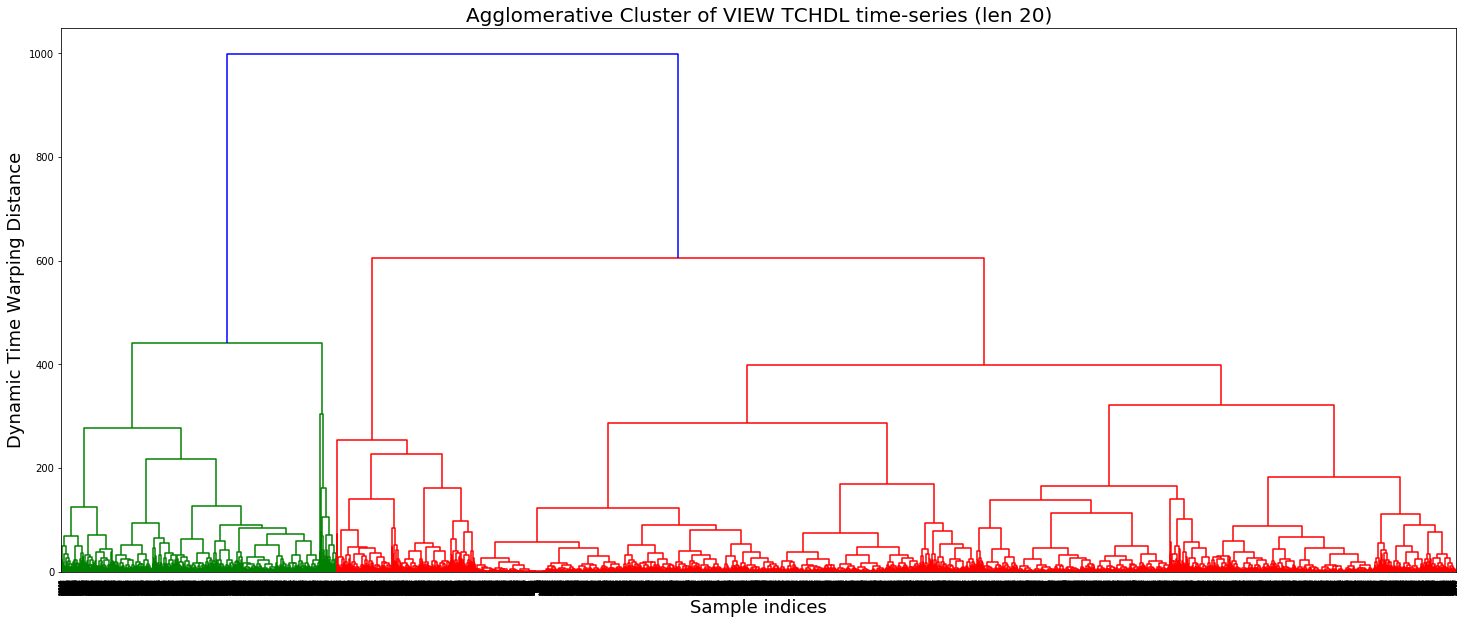

In [72]:
start_time = time.time()
Z = hierarchy.linkage(condensed_matrix, 'ward')
end_time = time.time()
print("Time took for agglomerative clustering: ", end_time-start_time)
############################################
# check Cophenetic Correlation Coefficient
# Compares the pairwise distance of samples
# to hierarchical clustering results
# should be close to 1
############################################
#cophenet_corr, coph_dist = hierarchy.cophenet(Z, condensed_matrix)

#print("Cophenetic correlation distances: ", cophenet_corr)

fig = pyplot.figure(figsize=(25, 10))
pyplot.title("Agglomerative Cluster of VIEW TCHDL time-series (len 20)", fontsize=20)
pyplot.xlabel("Sample indices", fontsize=18)
pyplot.ylabel("Dynamic Time Warping Distance", fontsize=18)
dn = hierarchy.dendrogram(Z)
pyplot.show()

In [73]:
cophenet_corr, coph_dist = hierarchy.cophenet(Z, condensed_matrix)

print("Cophenetic correlation distances: ", cophenet_corr)

Cophenetic correlation distances:  0.43757147199697194


In [74]:
print(Z.shape)
pd.DataFrame(Z).to_csv('/home/whsu014/data/DTW_21000inds_Z_ward.csv', sep=',')

(20999, 4)


In [79]:
cutree = scipy.cluster.hierarchy.cut_tree(Z, n_clusters=[5, 6, 7, 8]) #[3, 4, 5, 6, 7, 8, 9, 10])#[3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18]) #[3, 4, 5, 6, 7, 8, 9, 10]
print(cutree[-10:, ])
print(cutree.shape)
print(np.unique(cutree[:, 0]))
print(np.unique(cutree[:, 1]))
print(np.unique(cutree[:, 2]))
#print(np.unique(cutree[:, 3]))
#print(np.unique(cutree[:, 4]))
#print(np.unique(cutree[:, 5]))
#print(cutree.shape[0])
#print(cutree.shape[1])

[[1 1 1 1]
 [0 3 3 4]
 [3 4 4 5]
 [1 1 1 1]
 [0 3 3 4]
 [1 1 1 1]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [3 4 4 5]]
(21000, 4)
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5 6]


In [80]:
print(VIEW_sub_df.shape)
print(DTW_VIEW_v.shape)
print(DTW_VIEW_sub_v.shape)

(588000, 33)
(420000, 34)
(420000, 34)


In [84]:
### import sys
#np.set_printoptions(threshold=sys.maxsize, suppress=True)
#VIEW_sub_v = VIEW_sub_df.values
#print(VIEW_sub_v.shape)  #data contain full 28 quarters
#print(DTW_VIEW_v.shape) # data contain only 20 quarters post PREDICT
'''
start_time = time.time()
clusters_map = np.zeros((420000, 4))
clusters_map.fill(np.nan)
for i in range(cutree.shape[0]):
    for j in range(cutree.shape[1]):
        cluster = [cutree[i, j]]*20
        clusters_map[(i*20):((i+1)*20), j] = np.array(cluster).T
DTW_VIEW_clusters_v = np.append(DTW_VIEW_sub_v, clusters_map, axis=1)
print(DTW_VIEW_clusters_v.base is DTW_VIEW_sub_v)
print(DTW_VIEW_clusters_v.shape)
'''
VIEW_clusters_df = pd.DataFrame(DTW_VIEW_clusters_v)
VIEW_clusters_df.columns = [['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 
                            'AGE', 'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 
                           'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS', 
                           'ATORVASTATIN', 'SIMVASTATIN', 
                           'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL',
                           'TRUE_TCHDL', 'SBP', 'DBP',
                           'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 
                           'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 
                           'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR',
                           'NORMALISED_TCHDL',
                           '5CLUSTERS', '5CLUSTERS','7CLUSTERS',
                           '8CLUSTERS']]#,
                           #'6CLUSTERS', '7CLUSTERS', '8CLUSTERS',
                           #'9CLUSTERS', '15CLUSTERS']]#, '11CLUSTERS',
                           #'12CLUSTERS', '13CLUSTERS']], '20CLUSTERS']]
end_time = time.time()
print(end_time - start_time)
print(VIEW_clusters_df.shape)
print(VIEW_clusters_df.isnull().sum())
VIEW_clusters_df.to_csv('/home/whsu014/data/DTW_JNorm_21000inds_5to8clusters_WardLinkage.csv', sep=",")


123.07418036460876
(420000, 38)
STUDENT_INDEX_MASTER         0
DATE                         0
QUARTERS                     0
AGE                          0
ETHNICITY                    0
SEX                          0
NZDEP                        0
TEST                         0
HDL                          0
LDL                          0
TRI                          0
TCL                          0
TCHDL                        0
STATINS                      0
ATORVASTATIN                 0
SIMVASTATIN                  0
TRUE_HDL                     0
TRUE_LDL                     0
TRUE_TRI                     0
TRUE_TCL                     0
TRUE_TCHDL                   0
SBP                          0
DBP                          0
SBP2                         0
DBP2                        20
SMOKING                     20
EN_TCHDL                  5400
HX_DIABETES                  0
FAMILY_HISTORY               0
HX_CVD                       0
GEN_LIPID                    0
RENAL  

In [101]:
for c in range(8):
    VIEW_clusters = DTW_VIEW_clusters_v[DTW_VIEW_clusters_v[:, -1] == c]
    print("SIZE of Cluster " + str(c+1) + ": " + str(VIEW_clusters.shape[0]//20))

SIZE of Cluster 1: 3549
SIZE of Cluster 2: 4572
SIZE of Cluster 3: 3900
SIZE of Cluster 4: 2966
SIZE of Cluster 5: 3678
SIZE of Cluster 6: 2086
SIZE of Cluster 7: 247
SIZE of Cluster 8: 2


In [93]:
print(VIEW_clusters.shape)
print(i)
print(VIEW_clusters[0:20, 2])

(46680, 37)
0
[8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]


False
Cluster 5
SIZE of Cluster 5: 249
Quarter 9		 Quartile 1:  3.669	 Quartile 2:  4.606	 Quartile 3:  5.464
Quarter 10		 Quartile 1:  3.799	 Quartile 2:  4.663	 Quartile 3:  5.497
Quarter 11		 Quartile 1:  3.856	 Quartile 2:  4.681	 Quartile 3:  5.705
Quarter 12		 Quartile 1:  4.002	 Quartile 2:  4.829	 Quartile 3:  5.816
Quarter 13		 Quartile 1:  4.318	 Quartile 2:  5.041	 Quartile 3:  6.054
Quarter 14		 Quartile 1:  4.434	 Quartile 2:  5.34	 Quartile 3:  6.344
Quarter 15		 Quartile 1:  5.054	 Quartile 2:  5.804	 Quartile 3:  6.64
Quarter 16		 Quartile 1:  5.518	 Quartile 2:  6.197	 Quartile 3:  6.95
Quarter 17		 Quartile 1:  4.927	 Quartile 2:  5.791	 Quartile 3:  6.813
Quarter 18		 Quartile 1:  4.3	 Quartile 2:  5.214	 Quartile 3:  6.329
Quarter 19		 Quartile 1:  3.893	 Quartile 2:  4.845	 Quartile 3:  5.841
Quarter 20		 Quartile 1:  3.682	 Quartile 2:  4.537	 Quartile 3:  5.521
Quarter 21		 Quartile 1:  3.637	 Quartile 2:  4.416	 Quartile 3:  5.347
Quarter 22		 Quartile 1:  3.485

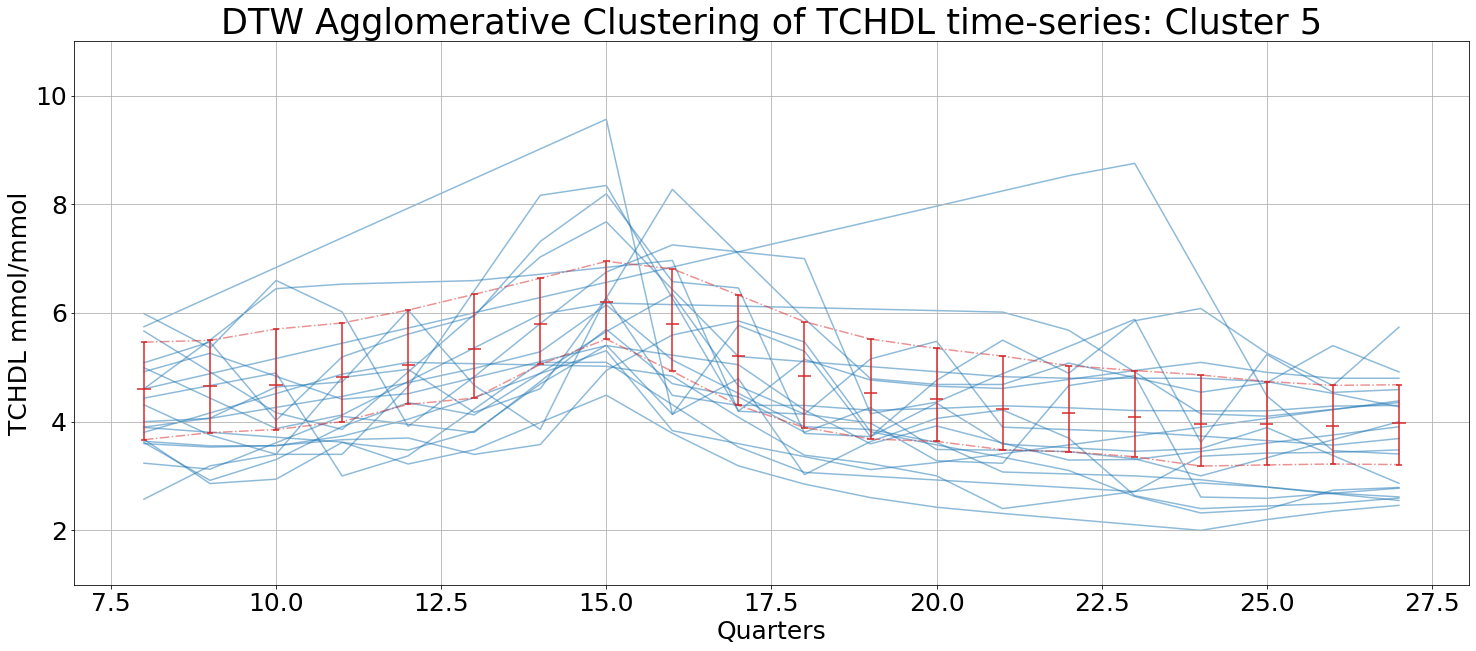

In [106]:

cluster_no = 4
#fig = pyplot.figure(figsize=(8, 10))
fig = pyplot.figure(figsize=(25, 10))
VIEW_clusters = DTW_VIEW_clusters_v[DTW_VIEW_clusters_v[:, -4] == cluster_no]
#VIEW_clusters_b = VIEW_clusters[VIEW_clusters[:, 2] < 8]
#VIEW_clusters_a = VIEW_clusters[VIEW_clusters[:, 2] >= 8]
#print(VIEW_clusters_b.shape)
#print(VIEW_clusters_a.shape)

print(VIEW_clusters.base is DTW_VIEW_clusters_v)
print("Cluster " + str(cluster_no+1))
print("SIZE of Cluster " + str(cluster_no+1) + ": " + str(VIEW_clusters.shape[0]//20))
##################################
# number of samples to plot
##################################
for i in range(20): 
    #quarters = VIEW_clusters_b[(i*8):((i+1)*8), 2]
    #TCHDL = VIEW_clusters_b[(i*8):((i+1)*8), 12]
    quarters = VIEW_clusters[(i*20):((i+1)*20), 2]
    TCHDL = VIEW_clusters[(i*20):((i+1)*20), 12]
    #quarters = VIEW_clusters[(i*28):((i+1)*28), 2]
    #TCHDL = VIEW_clusters[(i*28):((i+1)*28), 12]
    pyplot.plot(quarters, TCHDL, '-', color='C0', alpha=0.5, label="y", zorder=0)
###################################
# plot quartiles for each quarter
###################################
quartile_1_list = []
quartile_3_list = []
for i in range(8, 28): 
    quarter_cluster = VIEW_clusters[VIEW_clusters[:, 2] == i] #(i+8)    
    quartile_1 = np.quantile(quarter_cluster[:, 12], 0.25)
    quartile_2 = np.quantile(quarter_cluster[:, 12], 0.5)
    quartile_3 = np.quantile(quarter_cluster[:, 12], 0.75)
    quartile_1_list.append(quartile_1)
    quartile_3_list.append(quartile_3)
    pyplot.vlines((i), ymin=quartile_1, ymax=quartile_3, color='C3')
    pyplot.hlines(quartile_1, xmin=(i)-0.05, xmax=(i)+0.05, color='C3')
    pyplot.hlines(quartile_2, xmin=(i)-0.1, xmax=(i)+0.1, color='C3')
    pyplot.hlines(quartile_3, xmin=(i)-0.05, xmax=(i)+0.05, color='C3')
    print("Quarter " + str(i+1) + 
          "\t\t Quartile 1:  " + str(round(quartile_1, 3)) + 
          "\t Quartile 2:  " + str(round(quartile_2, 3)) + 
          "\t Quartile 3:  " + str(round(quartile_3, 3)))
pyplot.plot(np.array([8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]), #[0,1,2,3,4,5,6,7,
            np.array(quartile_1_list), '-.', color='C3', alpha=0.5)
pyplot.plot([8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], #[0,1,2,3,4,5,6,7,
            quartile_3_list, '-.', color='C3', alpha=0.5)
pyplot.grid()
pyplot.tick_params(axis='both', which='major', labelsize=25)
pyplot.ylim([1, 11])
#pyplot.title("Before PREDICT: Cluster " + str(cluster_no+1), fontsize=35)
pyplot.title("DTW Agglomerative Clustering of TCHDL time-series: Cluster " + str(cluster_no+1), fontsize=35)
pyplot.xlabel("Quarters", fontsize=25)
pyplot.ylabel("TCHDL mmol/mmol", fontsize=25)
fig_name = '/home/whsu014/plots/DTW_JNORM_WardLinkage_140Clusters_Cluster' + str(cluster_no+1) + 'len20_Quartiles_21000individuals.pdf'
fig.savefig(fig_name, bbox_inches='tight')
pyplot.show()


In [175]:
##################################
# Calculate the silhouette index 
##################################
distance_matrix = scipy.spatial.distance.squareform(condensed_matrix + condensed_matrix.T)
nodes = scipy.cluster.hierarchy.fcluster(Z, 11, criterion="maxclust")
print(len(nodes))
labels, counts = np.unique(nodes, return_counts= True)
print(labels)
print(counts)
silhouette_s = silhouette_score(distance_matrix , nodes, metric='euclidean')
print("Silhouette score: ", silhouette_s)

2500
[ 1  2  3  4  5  6  7  8  9 10 11]
[   3    1    1    1    1    1  964 1132    5   43  348]
Silhouette score:  0.36864077309168647


In [176]:
cophenet_corr, coph_dist = hierarchy.cophenet(Z, condensed_matrix)
print("Cophenet Correlation: ", cophenet_corr)
print(hierarchy.is_valid_linkage(Z))
print(hierarchy.is_monotonic(Z))

Cophenet Correlation:  0.6953160609511451
True
True


In [260]:
#print(Z[0:20, :])
#idx = np.argpartition(Z[:, 2], -11)[-11:]
#print(Z[idx, :])

print(Z[Z[:, 3]==1190])
print(Z[Z[:, 3]==995])
print(Z[Z[:, 3]==297])
print(np.where(Z[:, 3]==1190))
print(np.where(Z[:, 3]==995))
print(np.where(Z[:, 3]==297))
print("#####################")
print(Z[Z[:, 3]>995].shape)
print("#####################")
print(Z[Z[:, 3]>995])
print("#####################")
print(Z[-20:, ])

[[4947.         4977.           24.35837361 1190.        ]]
[[4770.        4980.          28.1279003  995.       ]]
[[4981.         4983.           30.76170018  297.        ]]
(array([2482]),)
(array([2484]),)
(array([2486]),)
#####################
(8, 4)
#####################
[[4957.         4967.           19.7637044  1097.        ]
 [4974.         4976.           21.41341916 1181.        ]
 [4947.         4977.           24.35837361 1190.        ]
 [4982.         4984.           32.31127788 2185.        ]
 [4989.         4992.           52.259762   2491.        ]
 [4993.         4994.           59.63749049 2494.        ]
 [1706.         4996.           84.3381637  2495.        ]
 [4995.         4997.          115.48339394 2500.        ]]
#####################
[[4966.         4968.           23.41723829  930.        ]
 [ 582.         4979.           23.91698489  931.        ]
 [4961.         4978.           24.30002718   21.        ]
 [4947.         4977.           24.35837361 1190. 

In [287]:
print(cutree.shape)
labels, counts = np.unique(cutree[:, -3], return_counts=True)
print(labels)
print(counts)
#label_0_idx = np.where(cutree[:, -3]==0)[0]
#label_1_idx = np.where(cutree[:, -3]==1)[0]
label_2_idx = np.where(cutree[:, -3]==2)[0]
#label_3_idx = np.where(cutree[:, -3]==3)
#label_4_idx = np.where(cutree[:, -3]==4)
#label_5_idx = np.where(cutree[:, -3]==5)
label_6_idx = np.where(cutree[:, -3]==6)[0]
#label_7_idx = np.where(cutree[:, -3]==7)
#label_8_idx = np.where(cutree[:, -3]==8)
#label_9_idx = np.where(cutree[:, -3]==9)
#label_10_idx = np.where(cutree[:, -3]==10)
print(label_2_idx.shape)
distance_list = []
for i in range(len(label_2_idx)):
    for j in range((i+1), len(label_2_idx)):
        distance_list.append(distance_matrix[label_2_idx[i],label_2_idx[j]])
#print(distance_list)
print(len(distance_list))
print("Average in cluster distace: "+ str(sum(distance_list)/len(distance_list)))

(2500, 9)
[ 0  1  2  3  4  5  6  7  8  9 10]
[1190  995  297    3    2    2    6    1    2    1    1]
(297,)
43956
Average in cluster distace: 39.37780592930413


In [282]:
print(distance_matrix.shape)

(2500, 2500)


In [294]:
print(VIEW_sub_v.shape)
labels, counts = np.unique(VIEW_sub_v[:, -3], return_counts=True)
print(labels)
print(counts)

(70000, 42)
[0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0]
[33320 27860  8316    84    56    56   168    28    56    28    28]


In [236]:
VIEW_cluster_df = pd.read_csv("/home/whsu014/data/DTW_J_normalised_16to18Clusters_2500inds20quarters.csv")
print(VIEW_cluster_df.shape)
print(VIEW_cluster_df.columns)
DTW_VIEW_clusters_v = VIEW_cluster_df.iloc[:, 1:].values

(50000, 38)
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE',
       'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL',
       'TCHDL', 'STATINS', 'ATORVASTATIN', 'SIMVASTATIN', 'TRUE_HDL',
       'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL', 'SBP', 'DBP', 'SBP2',
       'DBP2', 'SMOKING', 'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY',
       'HX_CVD', 'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'NORMALISED_TCHDL',
       '16CLUSTERS', '17CLUSTERS', '18CLUSTERS'],
      dtype='object')


['F' 'M']
['F' 'M']
[1080 1380]


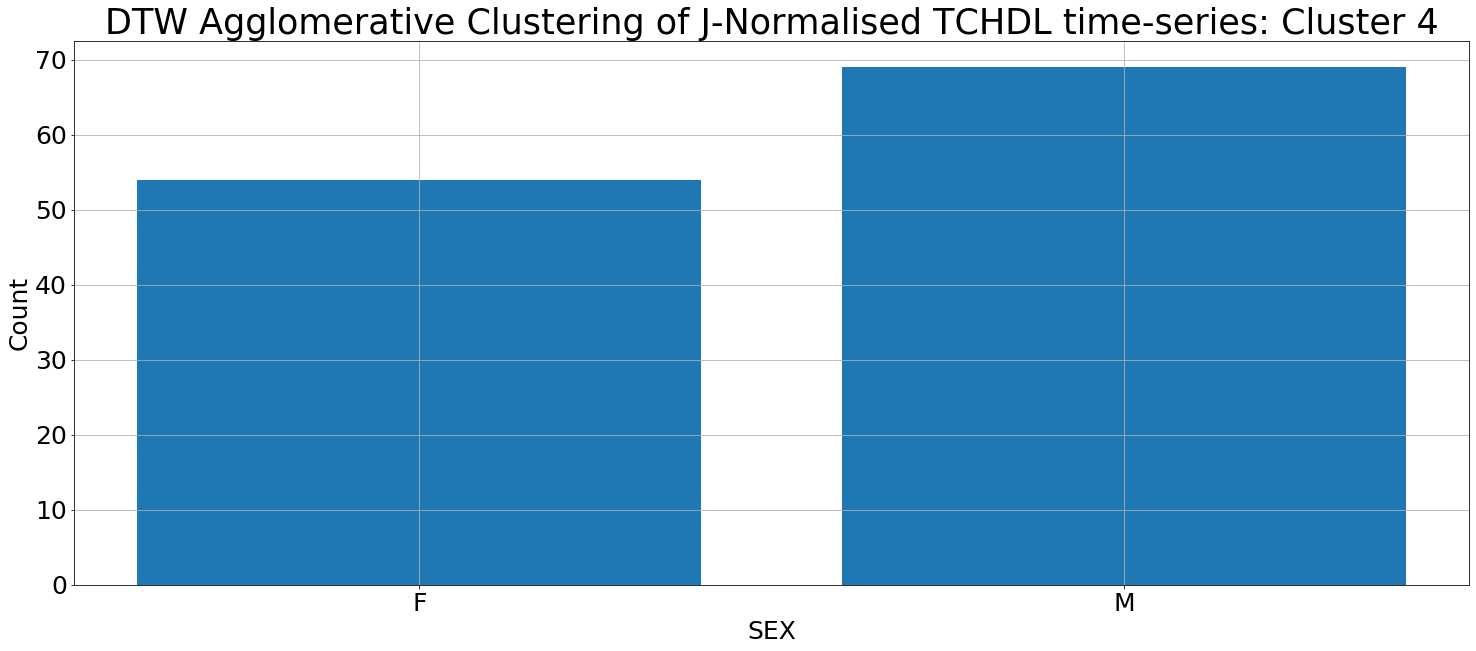

In [251]:
cluster_no = 3
VIEW_clusters = DTW_VIEW_clusters_v[DTW_VIEW_clusters_v[:, -2]==cluster_no]
print(np.unique(VIEW_clusters[:, 5]))
sex_labs, counts = np.unique(VIEW_clusters[:, 5], return_counts=True)
print(sex_labs)
print(counts)

fig = pyplot.figure(figsize=(25, 10))
pyplot.bar(sex_labs, counts//20)
pyplot.grid()
pyplot.tick_params(axis='both', which='major', labelsize=25)
pyplot.title("DTW Agglomerative Clustering of J-Normalised TCHDL time-series: Cluster " + str(cluster_no+1), fontsize=35)
pyplot.xlabel("SEX", fontsize=25)
pyplot.ylabel("Count", fontsize=25)
fig_name = '/home/whsu014/plots/DescriptivePlotDTWClusteringJNormalisedTCHDL Cluster' + str(cluster_no+1) + ' 20quarters2500IndividualsSex.pdf'
fig.savefig(fig_name, bbox_inches='tight')



['A' 'B' 'C' 'D' 'E' 'G' 'H']
[160 360 480 120 520 240 580]


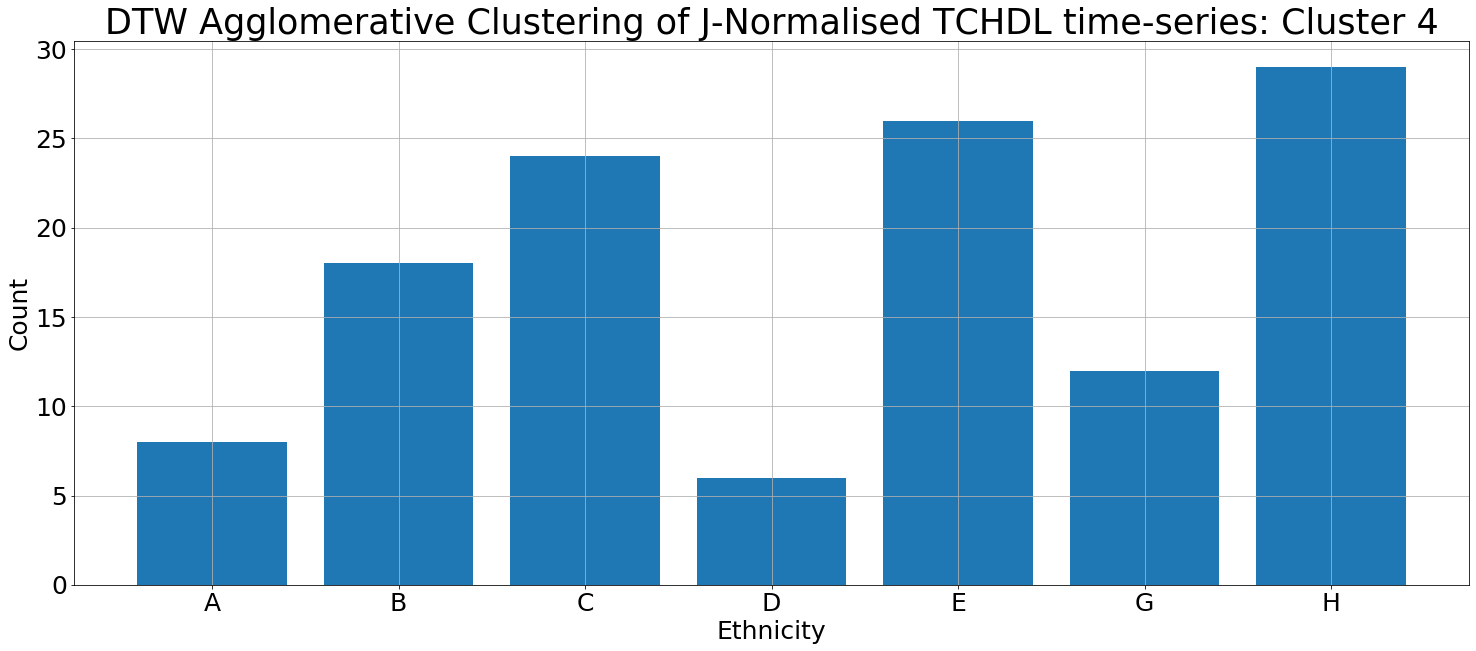

In [252]:
ethn_labs, counts = np.unique(VIEW_clusters[:, 4], return_counts=True) #Ethn
print(ethn_labs)
print(counts)

fig = pyplot.figure(figsize=(25, 10))
pyplot.bar(ethn_labs, counts//20)
pyplot.grid()
pyplot.tick_params(axis='both', which='major', labelsize=25)
pyplot.title("DTW Agglomerative Clustering of J-Normalised TCHDL time-series: Cluster " + str(cluster_no+1), fontsize=35)
pyplot.xlabel("Ethnicity", fontsize=25)
pyplot.ylabel("Count", fontsize=25)
fig_name = '/home/whsu014/plots/DescriptivePlotDTWClusteringJNormalisedTCHDL Cluster' + str(cluster_no+1) + ' 20quarters2500IndividualsEthnicity.pdf'
fig.savefig(fig_name, bbox_inches='tight')

[1 2 3 4 5]
[300 320 380 680 780]


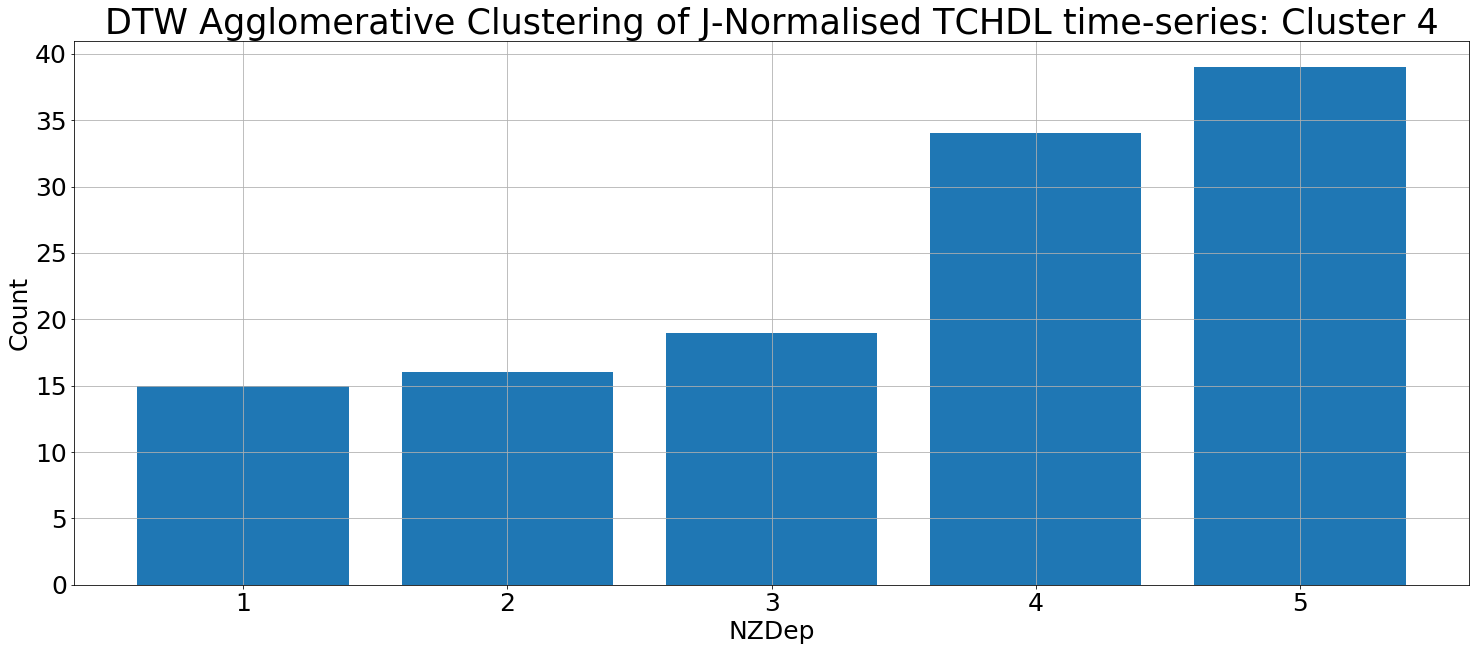

In [253]:
nzdep_labs, counts = np.unique(VIEW_clusters[:, 6], return_counts=True) #nzdep
print(nzdep_labs)
print(counts)


fig = pyplot.figure(figsize=(25, 10))
pyplot.bar(nzdep_labs, counts//20)
pyplot.grid()
pyplot.tick_params(axis='both', which='major', labelsize=25)
pyplot.title("DTW Agglomerative Clustering of J-Normalised TCHDL time-series: Cluster " + str(cluster_no+1), fontsize=35)
pyplot.xlabel("NZDep", fontsize=25)
pyplot.ylabel("Count", fontsize=25)
fig_name = '/home/whsu014/plots/DescriptivePlotDTWClusteringJNormalisedTCHDL Cluster' + str(cluster_no+1) + ' 20quarters2500IndividualsNZDep.pdf'
fig.savefig(fig_name, bbox_inches='tight')

(123, 37)
54.959349593495936


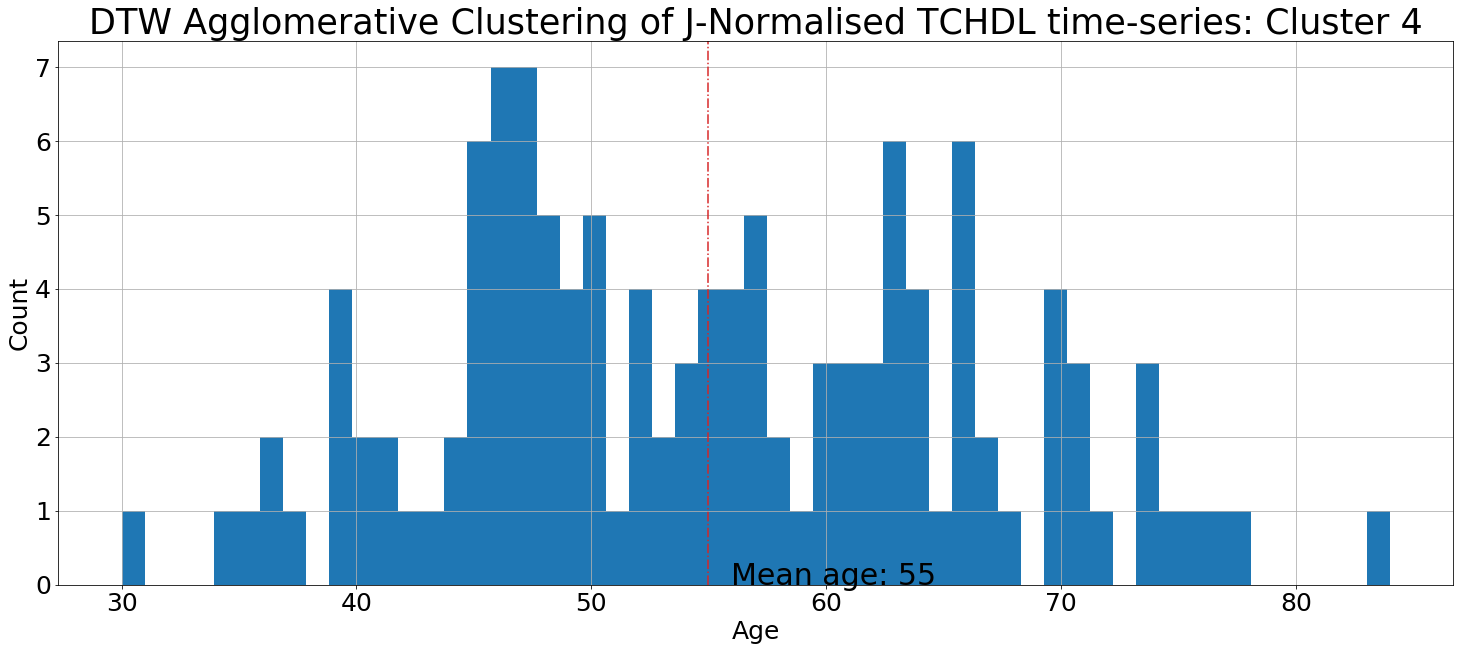

In [255]:
#nzdep_labs, counts = np.unique(cluster_1[:, 3], return_counts=True) #age
age_data = VIEW_clusters[VIEW_clusters[:, 2]==8] #used 8 for 20 quarters 7 for 28 quarters select quarter containing PREDICT assessment
print(age_data.shape)
#print(nzdep_labs)
#print(counts)
mean_age = np.mean(age_data[:, 3])
print(mean_age)


fig = pyplot.figure(figsize=(25, 10))
pyplot.hist(age_data[:, 3], bins=55)
pyplot.axvline(mean_age, color='C3', linestyle='-.')
pyplot.grid()
pyplot.tick_params(axis='both', which='major', labelsize=25)
pyplot.text(mean_age+1, 0, "Mean age: " + str(round(mean_age)), fontsize=30)
pyplot.title("DTW Agglomerative Clustering of J-Normalised TCHDL time-series: Cluster " + str(cluster_no+1), fontsize=35)
pyplot.xlabel("Age", fontsize=25)
pyplot.ylabel("Count", fontsize=25)
fig_name = '/home/whsu014/plots/DescriptivePlotDTWClusteringJNormalisedTCHDL Cluster' + str(cluster_no+1) + ' 20quarters2500IndividualsAge.pdf'
fig.savefig(fig_name, bbox_inches='tight')